In [1]:
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

import mcg
import mdtraj as md
import time
import pandas as pd

In [2]:
mu = 160
run = 4
idx = 1
burst = 1e5
stride = 1

In [3]:
folder = f"archive/data_unwrapped_error/data_mu{mu}/run{run}/"

conffolder = "gro_files"

In [4]:
def read_xyz_trajectory(xyz_filename):
    """
    Reads an XYZ trajectory file written by OpenMM and reconstructs the trajectory data.
    
    Args:
        xyz_filename (str): Path to the XYZ file
        
    Returns:
        dict: A dictionary containing:
            - 'positions' (np.ndarray): Array of shape (n_frames, n_atoms, 3)
            - 'box_lengths' (np.ndarray): Array of shape (n_frames,)
            - 'steps' (np.ndarray): Array of step numbers for each frame
            - 'elements' (list): List of element symbols for each atom
    """
    with open(xyz_filename, 'r') as f:
        lines = f.readlines()
    
    frames = []
    current_frame = {}
    box_lengths = []
    steps = []
    
    i = 0
    while i < len(lines):
        # Read number of atoms
        if not lines[i].strip():
            i += 1
            continue
            
        n_atoms = int(lines[i].strip())
        i += 1
        
        # Read step and box length information
        header = lines[i].strip()
        i += 1
        
        # Parse step number and box length
        step_str, _, box_str = header.partition(' at L : ')
        step = int(step_str.replace('Step ', ''))
        box_length = float(box_str)
        
        # Read atomic positions
        positions = []
        elements = []
        for _ in range(n_atoms):
            parts = lines[i].strip().split()
            elements.append(parts[0])
            positions.append([float(x) for x in parts[1:4]])
            i += 1
        
        # Store frame data
        frames.append(np.array(positions, dtype=np.float64))
        box_lengths.append(box_length)
        steps.append(step)
        
        # Store elements only once (assuming they don't change)
        if 'elements' not in current_frame:
            current_frame['elements'] = elements
    
    # Convert to numpy arrays
    current_frame['positions'] = np.array(frames)  # Shape: (n_frames, n_atoms, 3)
    current_frame['box_lengths'] = np.array(box_lengths)
    current_frame['steps'] = np.array(steps)
    
    return current_frame

# Usage example:
traj_data = read_xyz_trajectory(os.path.join(folder, f"trial_{idx}.xyz"))

# To get similar data structure as your original code:
# positions_value equivalent for first frame: traj_data['positions'][0]
# boxlength_value equivalent for first frame: traj_data['box_lengths'][0]
# step number equivalent: traj_data['steps'][0]

In [5]:
# Input files
# folder = "../../data/T_250_P_500/simulation_co2_system_N_2000k_222000k_T_250_P_500_v3"
# xtc_file = os.path.join(folder, "output.xtc")
dcd_file = os.path.join(folder, f"rejected_traj_trial_{idx}.dcd")
topology_file = os.path.join(conffolder, "conf.gro")


# Load the trajectory with a stride of n (e.g., every 10th frame)
n = stride  # Change this to the desired interval
traj = md.load(dcd_file, top=topology_file, stride=n)
original_frame_indices = np.arange(traj.n_frames) * n

traj.time = np.arange(0, traj.n_frames) * burst * n


#traj.xyz = traj.xyz.astype('float32')


# Save the reduced trajectory as a .gro file
# Output file
# gro_file = "trajectory.gro"
# traj.save_gro(gro_file)

print(f"Trajectory loaded using every {n}th step")

Trajectory loaded using every 1th step


In [6]:
pos_xyz = traj_data['positions']
pos_traj = traj.xyz[1:]

box_lengths_xyz = traj_data['box_lengths']
box_lengths_traj = traj.unitcell_vectors[1:][:,0,0]

atom_1_xyz = pos_xyz[:, 0, 0]
atom_1_traj = pos_traj[:, 0, 0]

In [7]:
np.shape(pos_xyz)

(141, 13312, 3)

In [8]:
np.shape(box_lengths_traj)

(141,)

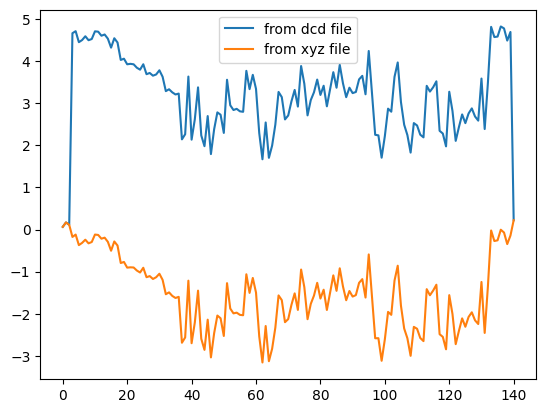

In [9]:
plt.plot(pos_traj[:, 0, 0], label='from dcd file')
plt.plot(pos_xyz[:, 0, 0], label='from xyz file')
plt.legend()

In [10]:
idx = 5

In [11]:
x_p_xyz = pos_xyz[idx, :, :]
x_p_traj = pos_traj[idx, :, :]

L_xyz = box_lengths_xyz[idx]
L_traj = box_lengths_traj[idx]

In [12]:
co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_xyz, L_xyz)
MCG_OP, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)

In [13]:
MCG_OP

146

In [14]:
co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_traj, L_traj)
MCG_OP, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)

In [15]:
MCG_OP

146

In [16]:
for idx in range(0, len(box_lengths_xyz), 1):
    x_p_xyz = pos_xyz[idx, :, :]
    x_p_traj = pos_traj[idx, :, :]
    
    L_xyz = box_lengths_xyz[idx]
    L_traj = box_lengths_traj[idx]
    
    co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_xyz, L_xyz)
    MCG_OP_xyz, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)
    
    co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_traj, L_traj)
    MCG_OP_traj, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)

    print(MCG_OP_xyz, MCG_OP_traj)

    if MCG_OP_xyz != MCG_OP_traj:
        print(f'DIFFERENT! at idx {idx}')

125 125
92 92
141 141
146 146
135 135
146 146
121 120
DIFFERENT! at idx 6
129 129
129 129
132 132
133 133
83 83
131 131
134 134
123 123
120 120
137 137
127 127
126 126
146 146
145 145
160 160
137 137
144 144
145 145
135 135


KeyboardInterrupt: 

In [17]:
idx = 6

x_p_xyz = pos_xyz[idx, :, :]
x_p_traj = pos_traj[idx, :, :]

L_xyz = box_lengths_xyz[idx]
L_traj = box_lengths_traj[idx]

co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_xyz, L_xyz)
MCG_OP_xyz, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)

co2_coms, water_coms, box_length = mcg.CO2ClathrateCOM(x_p_traj, L_traj)
MCG_OP_traj, _, _ = mcg.MCG_optimized(co2_coms, water_coms, box_length)

print(MCG_OP_xyz, MCG_OP_traj)

121 120
